# Clustering

Table of Contents
1. [A demo of K-Means clustering on the handwritten digits data](#A-demo-of-K-Means-clustering-on-the-handwritten-digits-data)
2. [A demo of the mean-shift clustering algorithm](#A-demo-of-the-mean-shift-clustering-algorithm)
3. [Compare BIRCH and MiniBatchKMeans](#Compare-BIRCH-and-MiniBatchKMeans)
4. [Comparing different clustering algorithms on toy datasets](#Comparing-different-clustering-algorithms-on-toy-datasets)
5. [Comparison of the K-Means and MiniBatchKMeans clustering algorithms](#Comparison-of-the-K-Means-and-MiniBatchKMeans-clustering-algorithms)
6. [Demo of DBSCAN clustering algorithm](#Demo-of-DBSCAN-clustering-algorithm)
7. [Demo of HDBSCAN clustering algorithm](#Demo-of-HDBSCAN-clustering-algorithm)
    1. [Hyperparameter Robustness](#Hyperparameter-Robustness)
8. [Vector Quantization Example](#Vector-Quantization-Example)

## A demo of K-Means clustering on the handwritten digits data

In this example we compare the various initialization strategies for K-means in terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated (see Clustering performance evaluation for definitions and discussions of the metrics):

| Shorthand  | full name                   |
| ---------  | ---------                   |
| homo       | homogeneity score           |
| compl      | completeness score          |
| v-meas     | V measure                   |
| ARI        | adjusted Rand index         | 
| AMI        | adjusted mutual information |
| silhouette | silhouette coefficient      |

In [3]:
import numpy as np

from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [4]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.198s	69545	0.598	0.645	0.621	0.469	0.617	0.156
random   	0.091s	69735	0.681	0.723	0.701	0.574	0.698	0.184
PCA-based	0.040s	69513	0.600	0.647	0.622	0.468	0.618	0.151
__________________________________________________________________________________


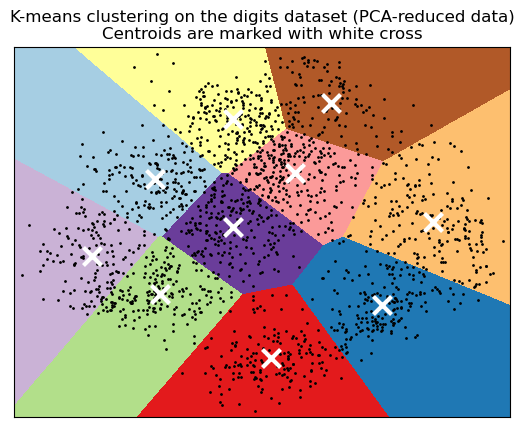

In [6]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# A demo of the mean-shift clustering algorithm

Mean shift clustering is a density-based, non-parametric clustering algorithm that identifies clusters by shifting data points towards the densest regions of the data. It doesn't require specifying the number of clusters beforehand and can handle clusters of various shapes. The algorithm works by iteratively moving data points towards the mean of their neighbors until convergence, effectively finding the modes of the data distribution

In [9]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

In [10]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10_000, centers=centers, cluster_std=0.6)

In [11]:
# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3


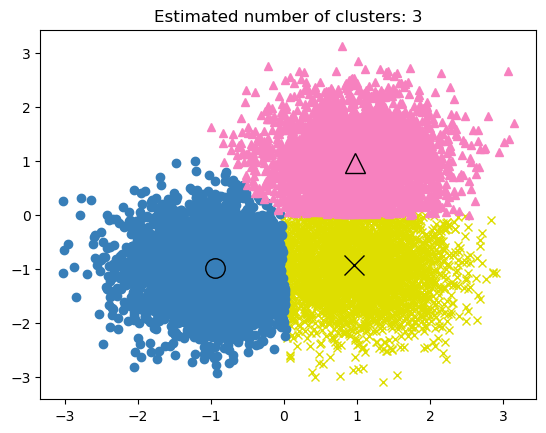

In [12]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.clf()

colors = ["#dede00", "#377eb8", "#f781bf"]
markers = ["x", "o", "^"]

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], markers[k], color=col)
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        markers[k],
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# Compare BIRCH and MiniBatchKMeans

This example compares the timing of BIRCH (with and without the global clustering step) and MiniBatchKMeans on a synthetic dataset having 25,000 samples and 2 features generated using make_blobs.

Both MiniBatchKMeans and BIRCH are very scalable algorithms and could run efficiently on hundreds of thousands or even millions of datapoints. We chose to limit the dataset size of this example in the interest of keeping our Continuous Integration resource usage reasonable but the interested reader might enjoy editing this script to rerun it with a larger value for n_samples.

If n_clusters is set to None, the data is reduced from 25,000 samples to a set of 158 clusters. This can be viewed as a preprocessing step before the final (global) clustering step that further reduces these 158 clusters to 100 clusters.

BIRCH without global clustering as the final step took 0.23 seconds
n_clusters : 158
BIRCH with global clustering as the final step took 0.71 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 0.20 seconds


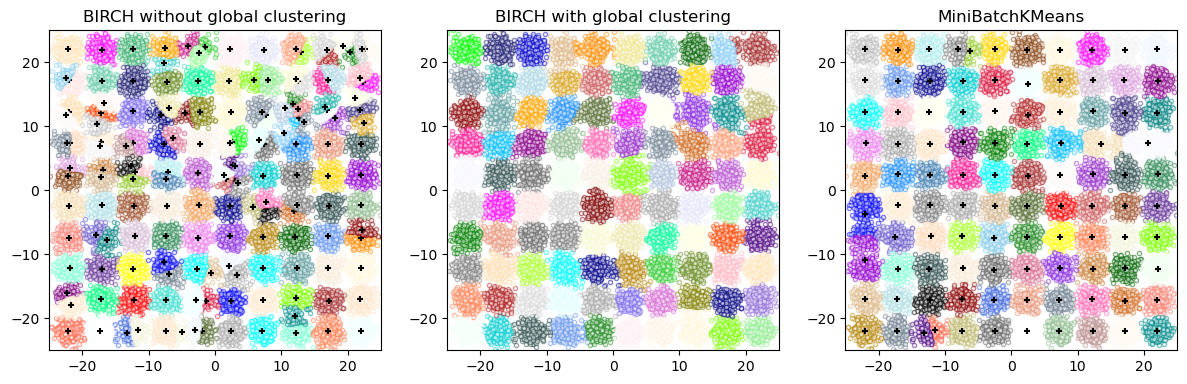

In [13]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from itertools import cycle
from time import time

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from joblib import cpu_count

from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets import make_blobs

# Generate centers for the blobs so that it forms a 10 X 10 grid.
xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centers = np.hstack((np.ravel(xx)[:, np.newaxis], np.ravel(yy)[:, np.newaxis]))

# Generate blobs to do a comparison between MiniBatchKMeans and BIRCH.
X, y = make_blobs(n_samples=25000, centers=n_centers, random_state=0)

# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# Compute clustering with BIRCH with and without the final clustering step
# and plot.
birch_models = [
    Birch(threshold=1.7, n_clusters=None),
    Birch(threshold=1.7, n_clusters=100),
]
final_step = ["without global clustering", "with global clustering"]

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    print("BIRCH %s as the final step took %0.2f seconds" % (info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1], c="w", edgecolor=col, marker=".", alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker="+", c="k", s=25)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title("BIRCH %s" % info)

# Compute clustering with MiniBatchKMeans.
mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=100,
    batch_size=256 * cpu_count(),
    n_init=10,
    max_no_improvement=10,
    verbose=0,
    random_state=0,
)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_, range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.scatter(X[mask, 0], X[mask, 1], marker=".", c="w", edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], this_centroid[1], marker="+", c="k", s=25)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()

# Comparing different clustering algorithms on toy datasets

This example shows characteristics of different clustering algorithms on datasets that are “interesting” but still in 2D. With the exception of the last dataset, the parameters of each of these dataset-algorithm pairs has been tuned to produce good clustering results. Some algorithms are more sensitive to parameter values than others.

The last dataset is an example of a ‘null’ situation for clustering: the data is homogeneous, and there is no good clustering. For this example, the null dataset uses the same parameters as the dataset in the row above it, which represents a mismatch in the parameter values and the data structure.

While these examples give some intuition about the algorithms, this intuition might not apply to very high dimensional data.

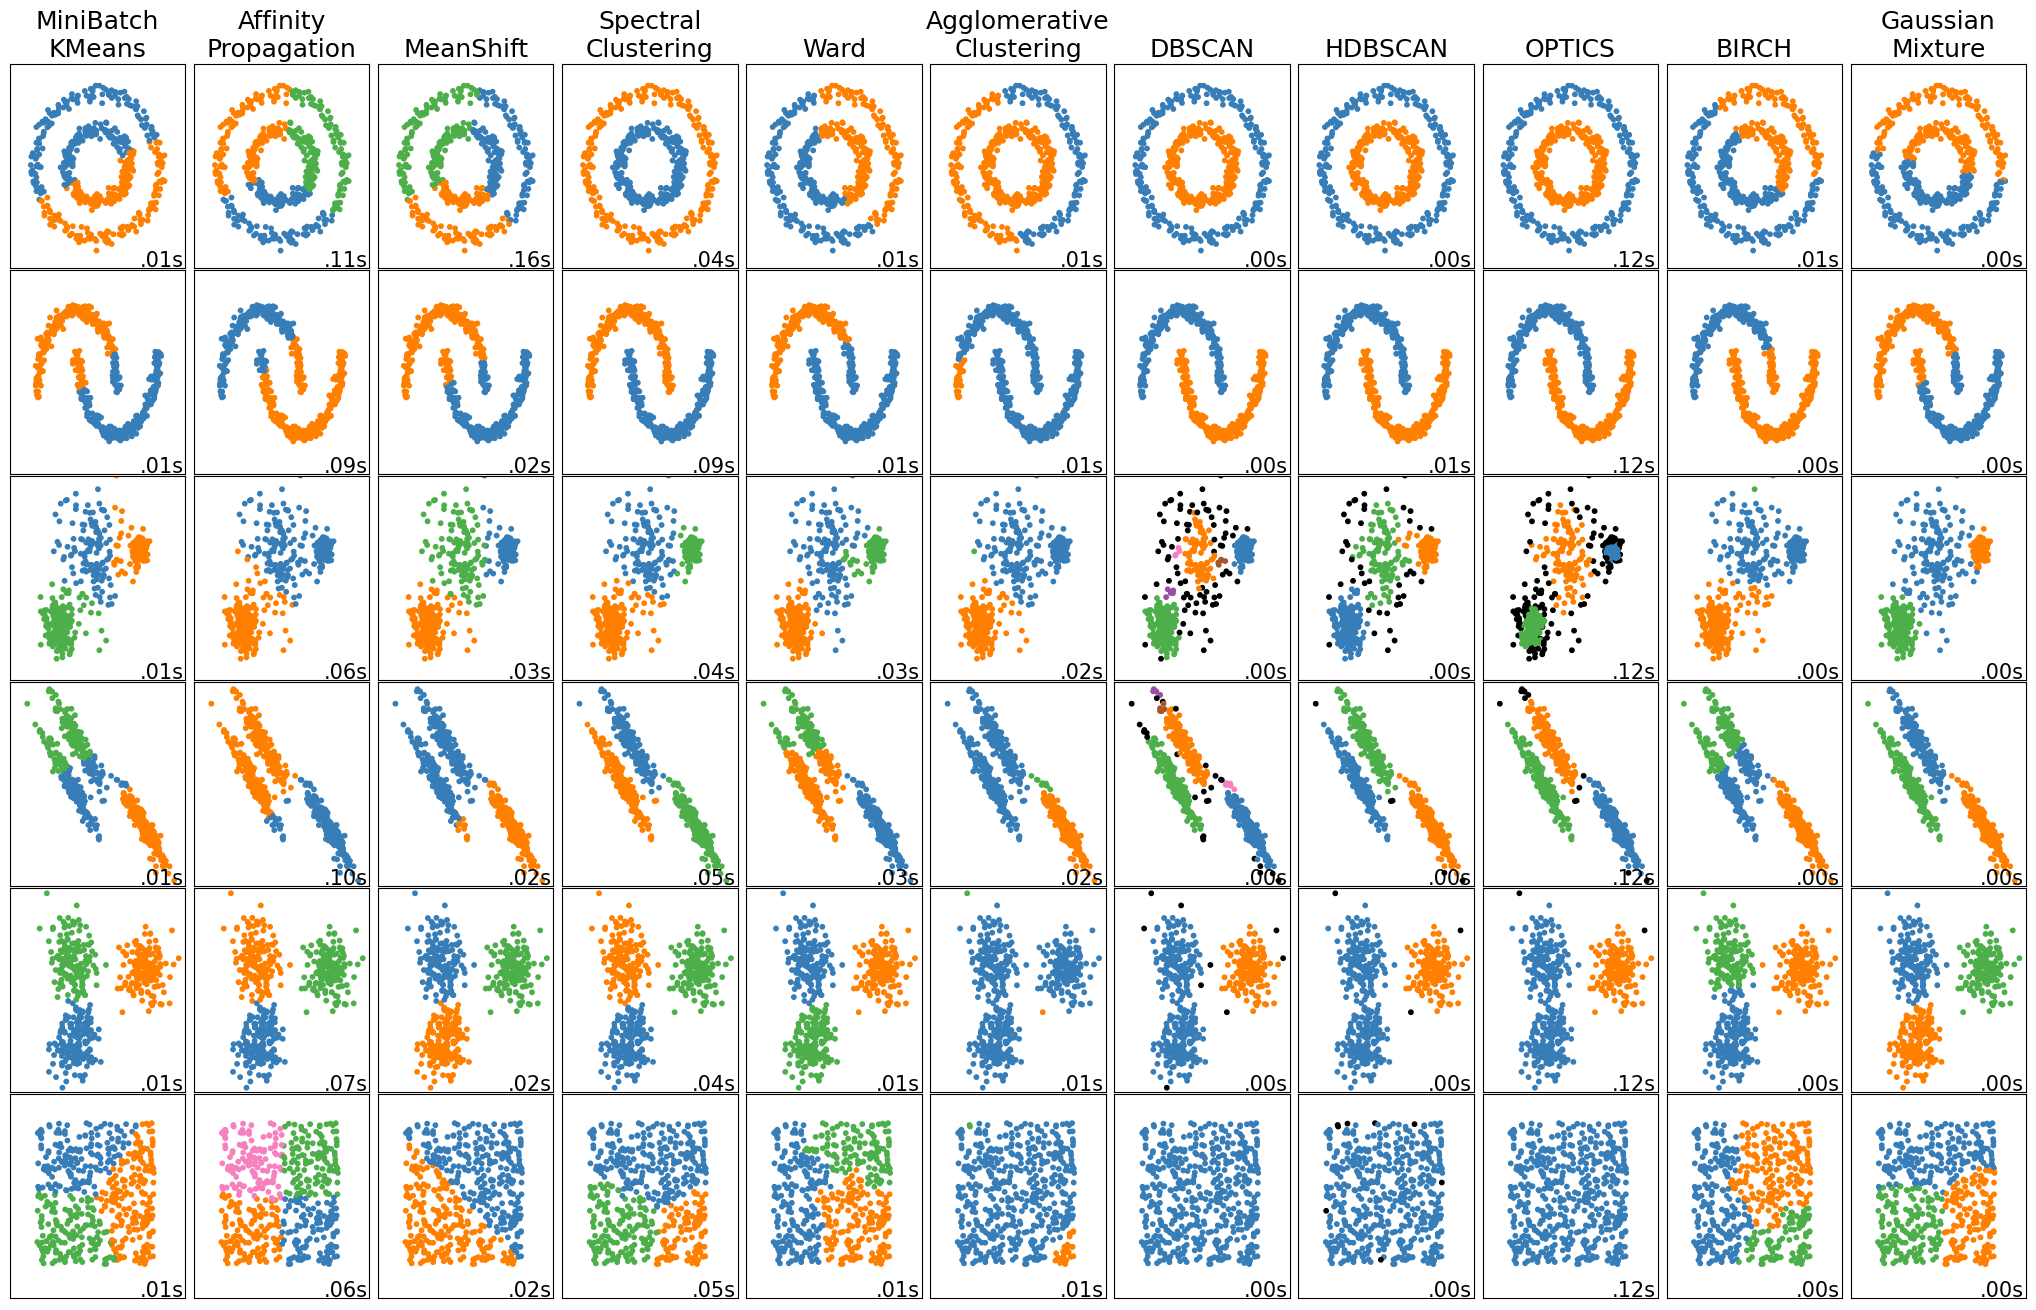

In [14]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                "connectivity matrix is [0-9]{1,2}"
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

# Comparison of the K-Means and MiniBatchKMeans clustering algorithms

We want to compare the performance of the MiniBatchKMeans and KMeans: the MiniBatchKMeans is faster, but gives slightly different results (see Mini Batch K-Means).

We will cluster a set of data, first with KMeans and then with MiniBatchKMeans, and plot the results. We will also plot the points that are labelled differently between the two algorithms.



In [15]:
import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [16]:
import time

from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

In [17]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

In [18]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

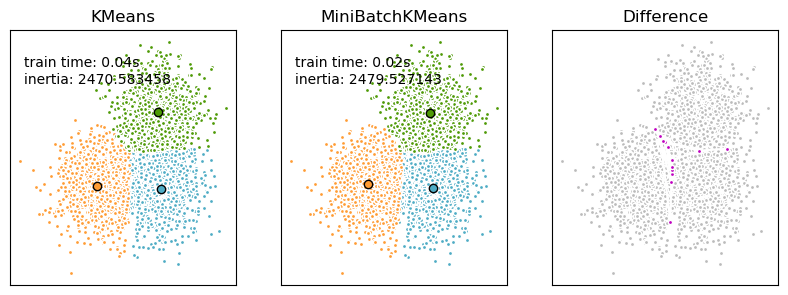

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()

# Demo of DBSCAN clustering algorithm

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) finds core samples in regions of high density and expands clusters from them. This algorithm is good for data which contains clusters of similar density.

See the Comparing different clustering algorithms on toy datasets example for a demo of different clustering algorithms on 2D datasets.

In [20]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

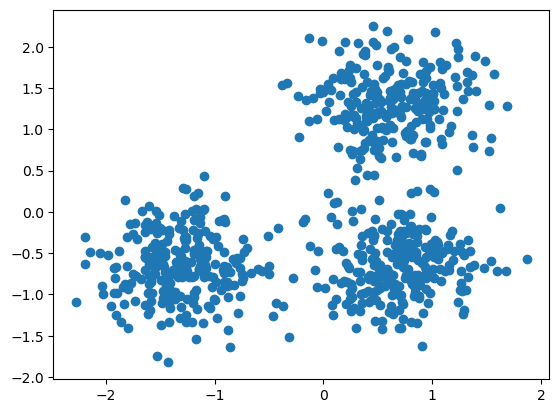

In [21]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [24]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 18


Clustering algorithms are fundamentally unsupervised learning methods. However, since make_blobs gives access to the true labels of the synthetic clusters, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters. Examples of such metrics are the homogeneity, completeness, V-measure, Rand-Index, Adjusted Rand-Index and Adjusted Mutual Information (AMI).

If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

For more information, see the Adjustment for chance in clustering performance evaluation example or the Clustering performance evaluation module.

In [25]:
print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


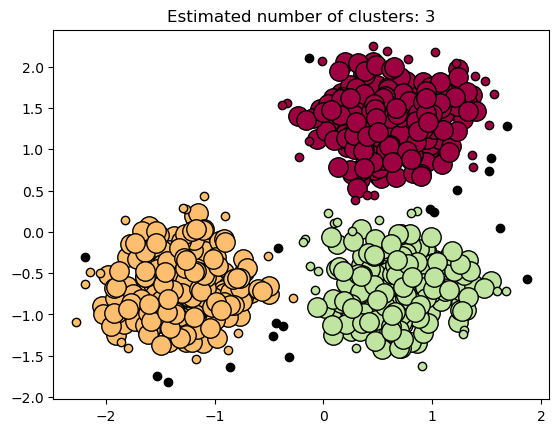

In [26]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

Core samples (large dots) and non-core samples (small dots) are color-coded according to the assigned cluster. Samples tagged as noise are represented in black.

# Demo of HDBSCAN clustering algorithm

In this demo we will take a look at cluster.HDBSCAN from the perspective of generalizing the cluster.DBSCAN algorithm. We’ll compare both algorithms on specific datasets. Finally we’ll evaluate HDBSCAN’s sensitivity to certain hyperparameters.

We first define a couple utility functions for convenience.

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.datasets import make_blobs


def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

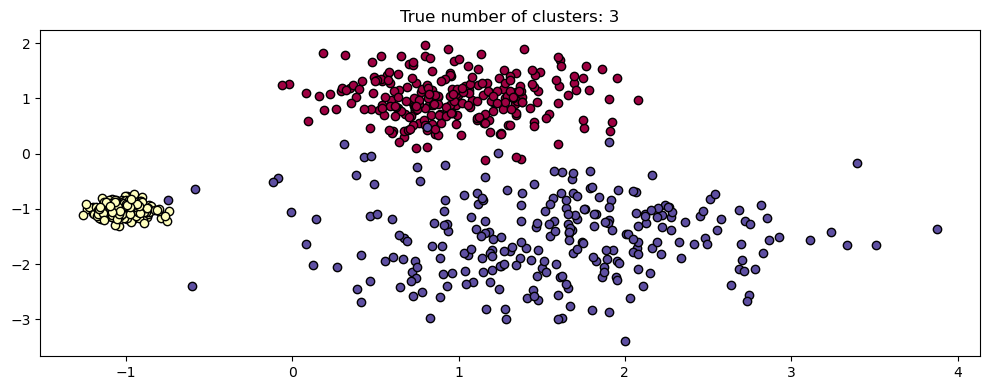

In [30]:
centers = [[1, 1], [-1, -1], [1.5, -1.5]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=[0.4, 0.1, 0.75], random_state=0
)
plot(X, labels=labels_true, ground_truth=True)

It’s worth remembering that, while DBSCAN provides a default value for eps parameter, it hardly has a proper default value and must be tuned for the specific dataset at use.

As a simple demonstration, consider the clustering for a eps value tuned for one dataset, and clustering obtained with the same value but applied to rescaled versions of the dataset.

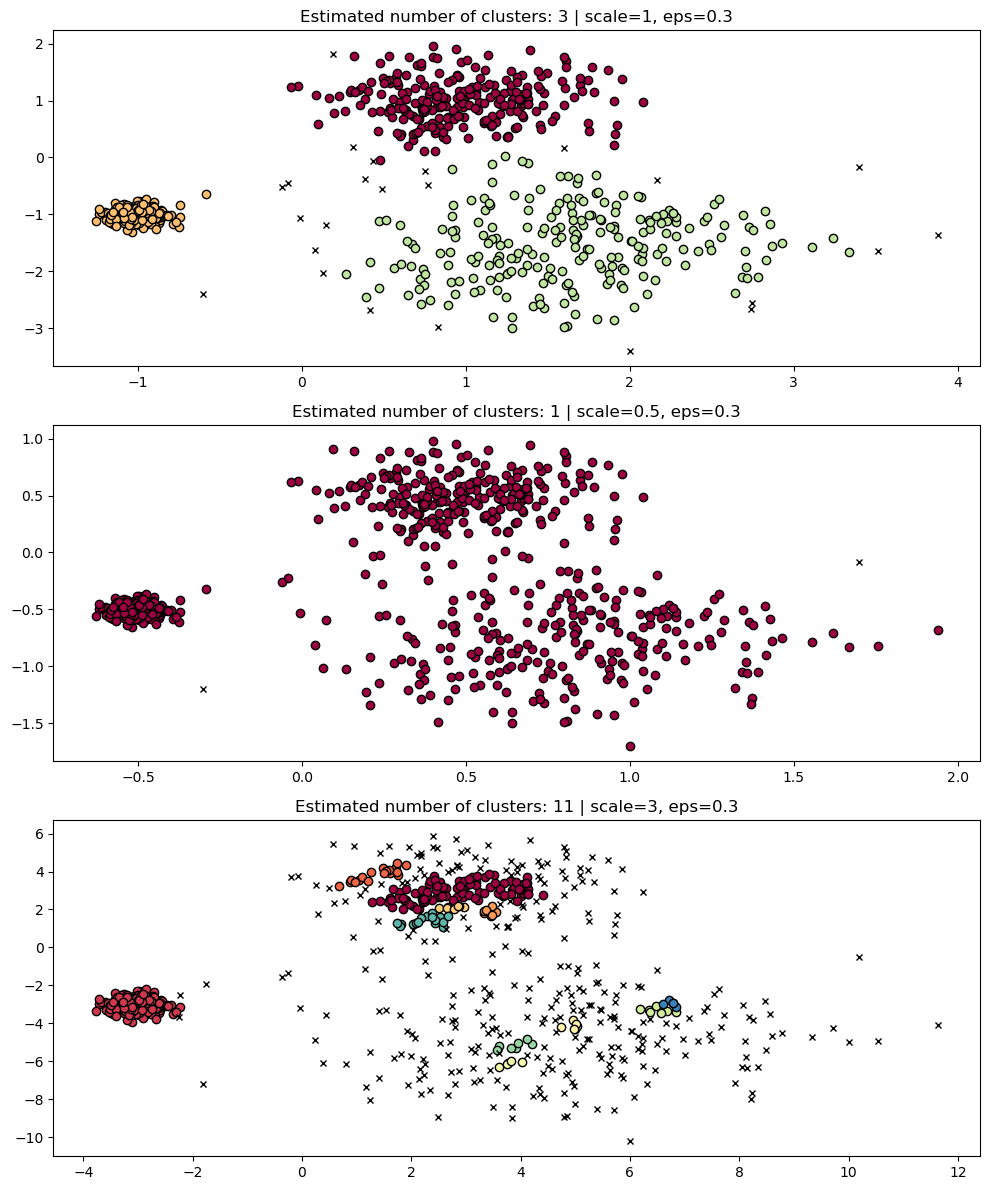

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
dbs = DBSCAN(eps=0.3)
for idx, scale in enumerate([1, 0.5, 3]):
    dbs.fit(X * scale)
    plot(X * scale, dbs.labels_, parameters={"scale": scale, "eps": 0.3}, ax=axes[idx])

Indeed, in order to maintain the same results we would have to scale eps by the same factor.

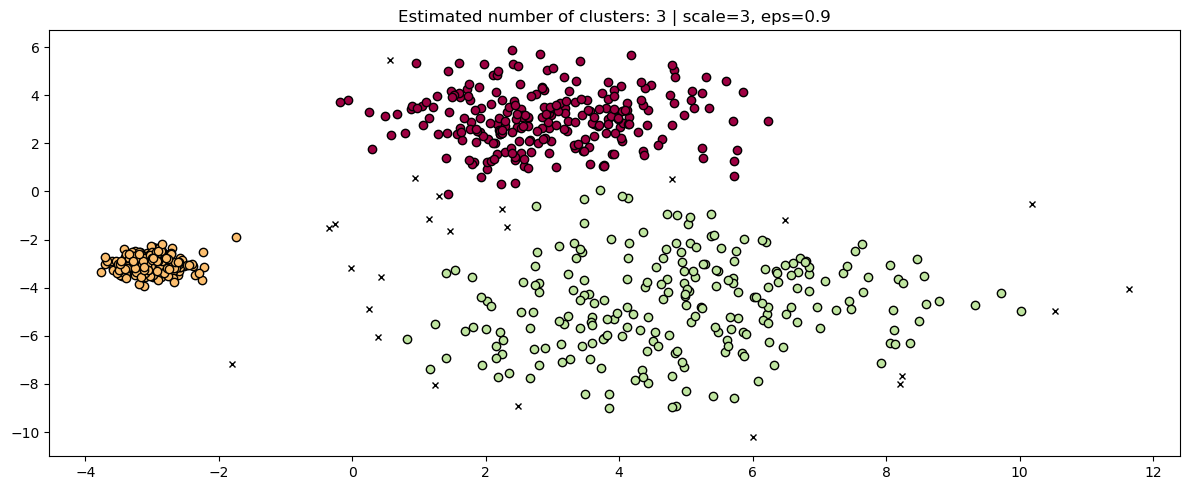

In [32]:
fig, axis = plt.subplots(1, 1, figsize=(12, 5))
dbs = DBSCAN(eps=0.9).fit(3 * X)
plot(3 * X, dbs.labels_, parameters={"scale": 3, "eps": 0.9}, ax=axis)

While standardizing data (e.g. using sklearn.preprocessing.StandardScaler) helps mitigate this problem, great care must be taken to select the appropriate value for eps.

HDBSCAN is much more robust in this sense: HDBSCAN can be seen as clustering over all possible values of eps and extracting the best clusters from all possible clusters (see User Guide). One immediate advantage is that HDBSCAN is scale-invariant.

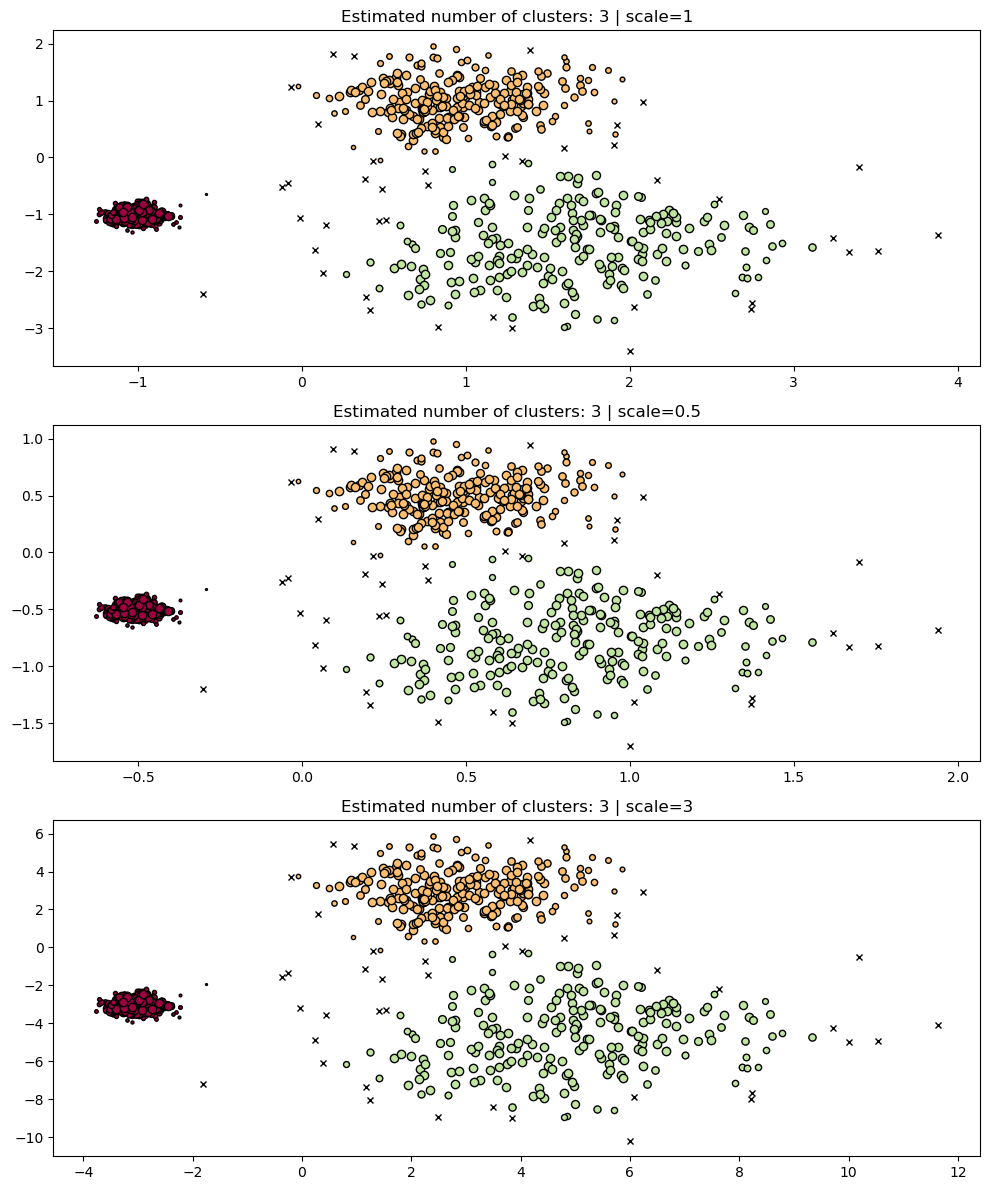

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
hdb = HDBSCAN()
for idx, scale in enumerate([1, 0.5, 3]):
    hdb.fit(X * scale)
    plot(
        X * scale,
        hdb.labels_,
        hdb.probabilities_,
        ax=axes[idx],
        parameters={"scale": scale},
    )

### Multi-Scale Clustering

HDBSCAN is much more than scale invariant though – it is capable of multi-scale clustering, which accounts for clusters with varying density. Traditional DBSCAN assumes that any potential clusters are homogeneous in density. HDBSCAN is free from such constraints. To demonstrate this we consider the following dataset

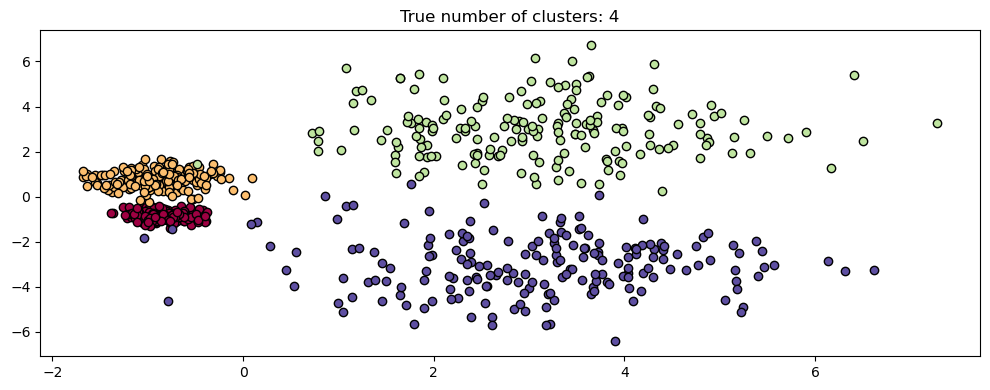

In [34]:
centers = [[-0.85, -0.85], [-0.85, 0.85], [3, 3], [3, -3]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=[0.2, 0.35, 1.35, 1.35], random_state=0
)
plot(X, labels=labels_true, ground_truth=True)

This dataset is more difficult for DBSCAN due to the varying densities and spatial separation:

If eps is too large then we risk falsely clustering the two dense clusters as one since their mutual reachability will extend clusters.

If eps is too small, then we risk fragmenting the sparser clusters into many false clusters.

Not to mention this requires manually tuning choices of eps until we find a tradeoff that we are comfortable with.

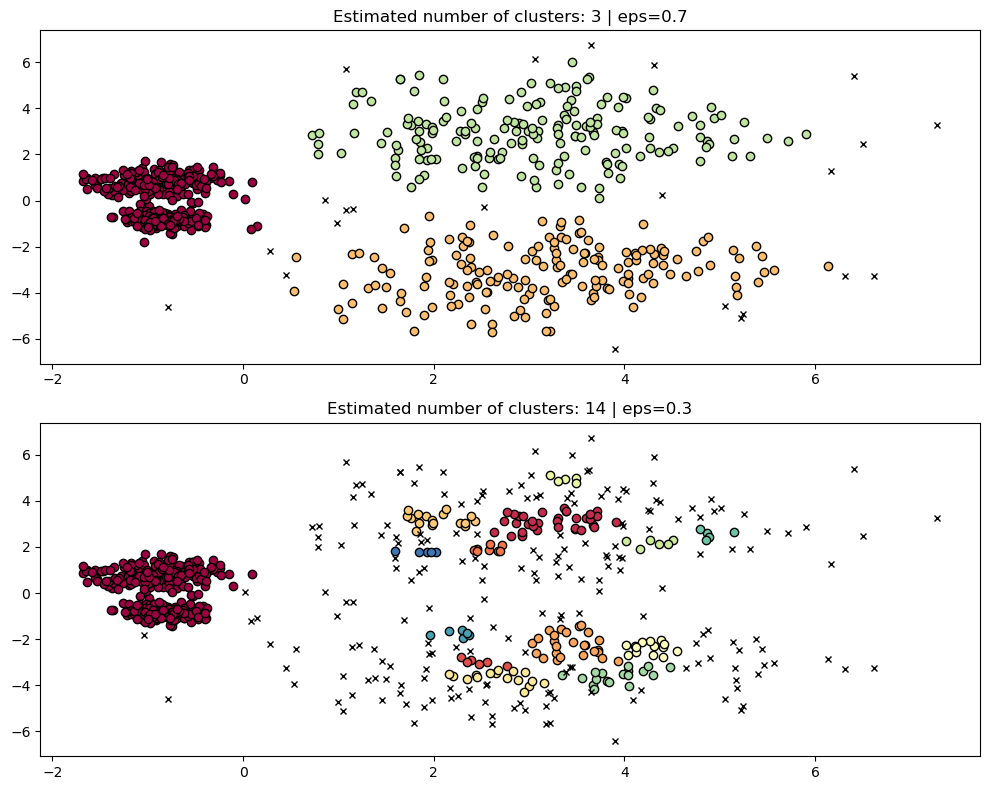

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
params = {"eps": 0.7}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[0])
params = {"eps": 0.3}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[1])

To properly cluster the two dense clusters, we would need a smaller value of epsilon, however at eps=0.3 we are already fragmenting the sparse clusters, which would only become more severe as we decrease epsilon. Indeed it seems that DBSCAN is incapable of simultaneously separating the two dense clusters while preventing the sparse clusters from fragmenting. Let’s compare with HDBSCAN.

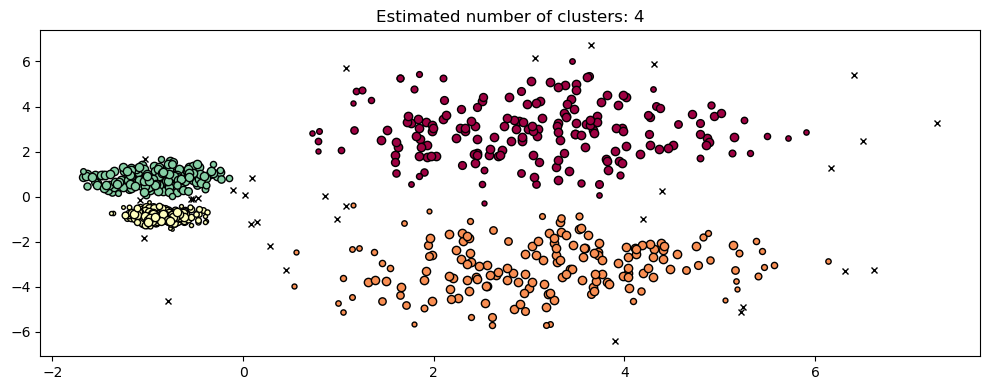

In [36]:
hdb = HDBSCAN().fit(X)
plot(X, hdb.labels_, hdb.probabilities_)

HDBSCAN is able to adapt to the multi-scale structure of the dataset without requiring parameter tuning. While any sufficiently interesting dataset will require tuning, this case demonstrates that HDBSCAN can yield qualitatively better classes of clusterings without users’ intervention which are inaccessible via DBSCAN.

## Hyperparameter Robustness

Ultimately tuning will be an important step in any real world application, so let’s take a look at some of the most important hyperparameters for HDBSCAN. While HDBSCAN is free from the eps parameter of DBSCAN, it does still have some hyperparameters like min_cluster_size and min_samples which tune its results regarding density. We will however see that HDBSCAN is relatively robust to various real world examples thanks to those parameters whose clear meaning helps tuning them.

### `min_cluster_size`
`min_cluster_size` is the minimum number of samples in a group for that group to be considered a cluster.

Clusters smaller than the ones of this size will be left as noise. The default value is 5. This parameter is generally tuned to larger values as needed. Smaller values will likely to lead to results with fewer points labeled as noise. However values which too small will lead to false sub-clusters being picked up and preferred. Larger values tend to be more robust with respect to noisy datasets, e.g. high-variance clusters with significant overlap.

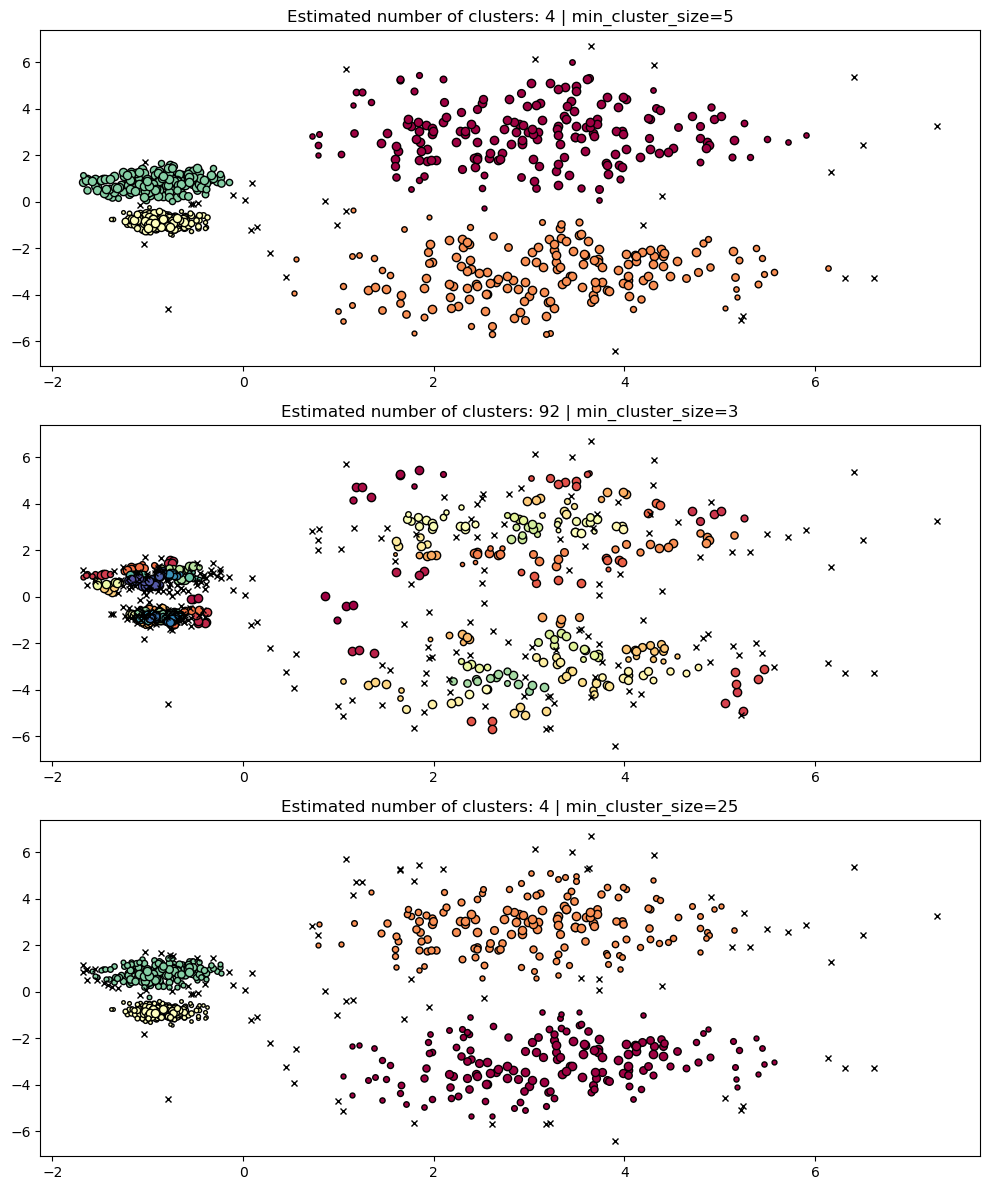

In [37]:
PARAM = ({"min_cluster_size": 5}, {"min_cluster_size": 3}, {"min_cluster_size": 25})
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(X)
    labels = hdb.labels_

    plot(X, labels, hdb.probabilities_, param, ax=axes[i])

### `min_samples`
`min_samples` is the number of samples in a neighborhood for a point to be considered as a core point, including the point itself. min_samples defaults to min_cluster_size. Similarly to min_cluster_size, larger values for min_samples increase the model’s robustness to noise, but risks ignoring or discarding potentially valid but small clusters. min_samples better be tuned after finding a good value for min_cluster_size.

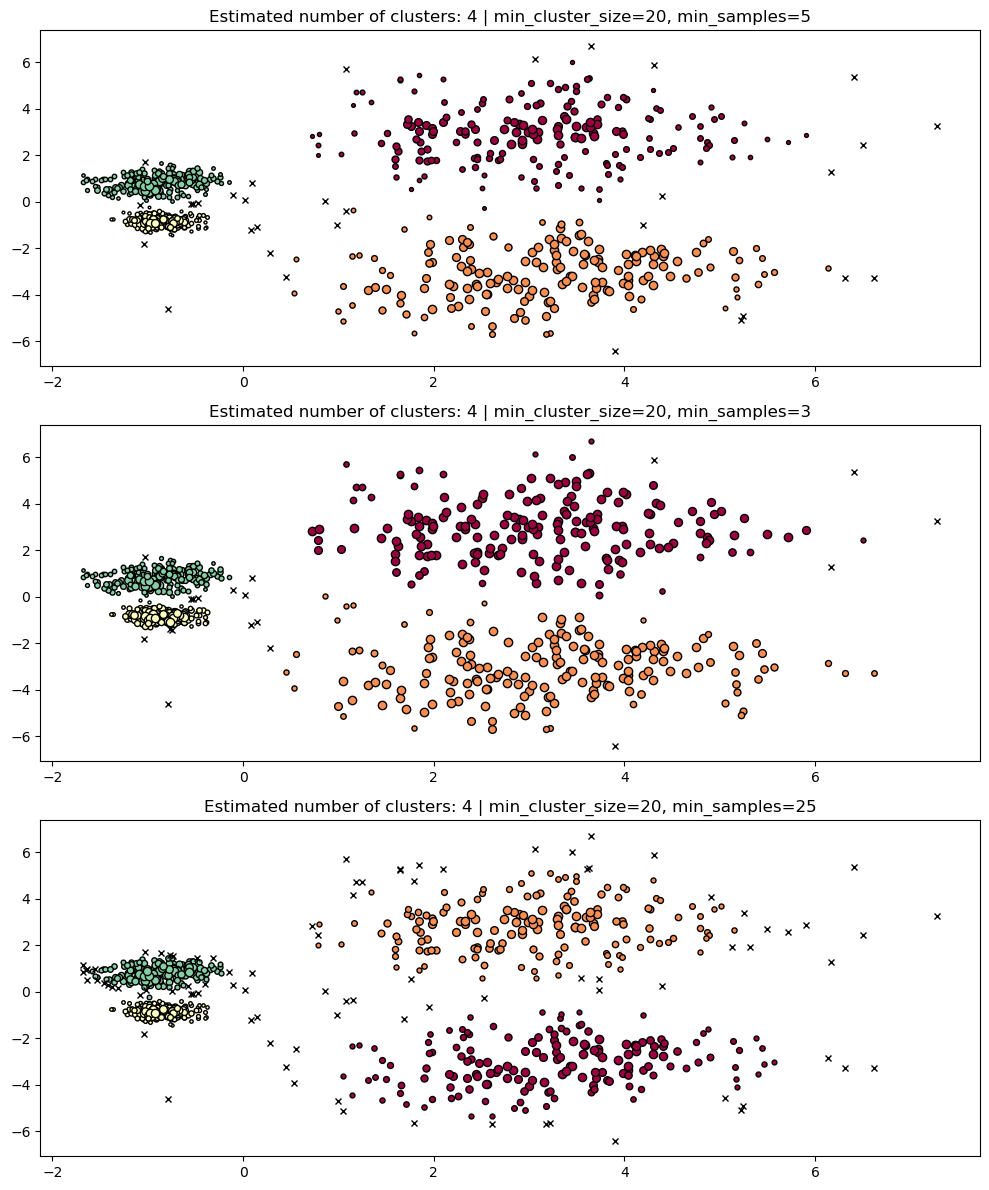

In [38]:
PARAM = (
    {"min_cluster_size": 20, "min_samples": 5},
    {"min_cluster_size": 20, "min_samples": 3},
    {"min_cluster_size": 20, "min_samples": 25},
)
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(X)
    labels = hdb.labels_

    plot(X, labels, hdb.probabilities_, param, ax=axes[i])

### `dbscan_clustering`
During fit, HDBSCAN builds a single-linkage tree which encodes the clustering of all points across all values of DBSCAN’s eps parameter. We can thus plot and evaluate these clusterings efficiently without fully recomputing intermediate values such as core-distances, mutual-reachability, and the minimum spanning tree. All we need to do is specify the cut_distance (equivalent to eps) we want to cluster with.

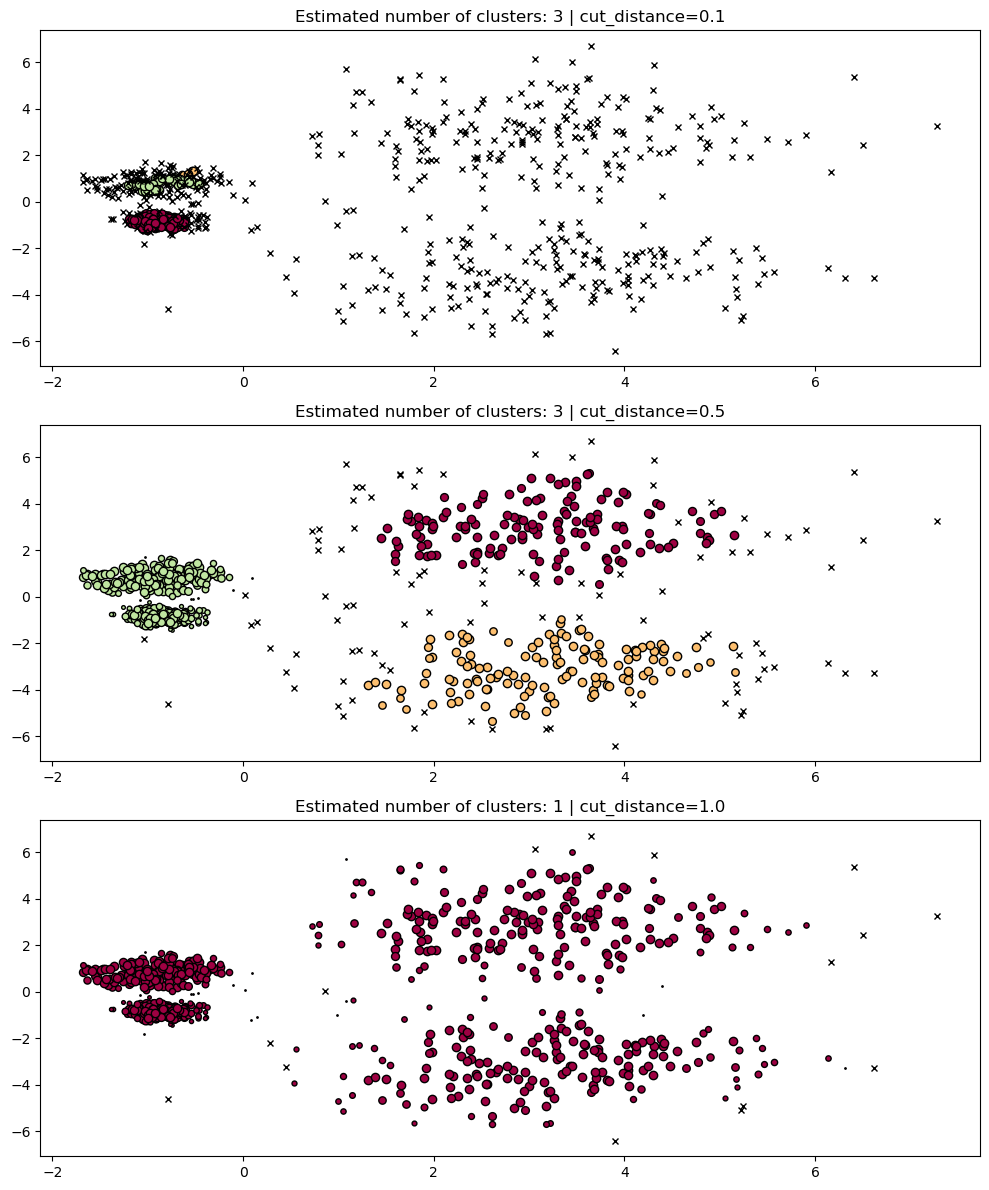

In [39]:
PARAM = (
    {"cut_distance": 0.1},
    {"cut_distance": 0.5},
    {"cut_distance": 1.0},
)
hdb = HDBSCAN()
hdb.fit(X)
fig, axes = plt.subplots(len(PARAM), 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    labels = hdb.dbscan_clustering(**param)

    plot(X, labels, hdb.probabilities_, param, ax=axes[i])

# Vector Quantization Example

This example shows how one can use KBinsDiscretizer to perform vector quantization on a set of toy image, the raccoon face.

We start by loading the raccoon face image from SciPy. We will additionally check a couple of information regarding the image, such as the shape and data type used to store the image.

Note that depending of the SciPy version, we have to adapt the import since the function returning the image is not located in the same module. Also, SciPy >= 1.10 requires the package pooch to be installed.

In [1]:
try:  # Scipy >= 1.10
    from scipy.datasets import face
except ImportError:
    from scipy.misc import face

raccoon_face = face(gray=True)

print(f"The dimension of the image is {raccoon_face.shape}")
print(f"The data used to encode the image is of type {raccoon_face.dtype}")
print(f"The number of bytes taken in RAM is {raccoon_face.nbytes}")

The dimension of the image is (768, 1024)
The data used to encode the image is of type uint8
The number of bytes taken in RAM is 786432


Thus the image is a 2D array of 768 pixels in height and 1024 pixels in width. Each value is a 8-bit unsigned integer, which means that the image is encoded using 8 bits per pixel. The total memory usage of the image is 786 kilobytes (1 byte equals 8 bits).

Using 8-bit unsigned integer means that the image is encoded using 256 different shades of gray, at most. We can check the distribution of these values.

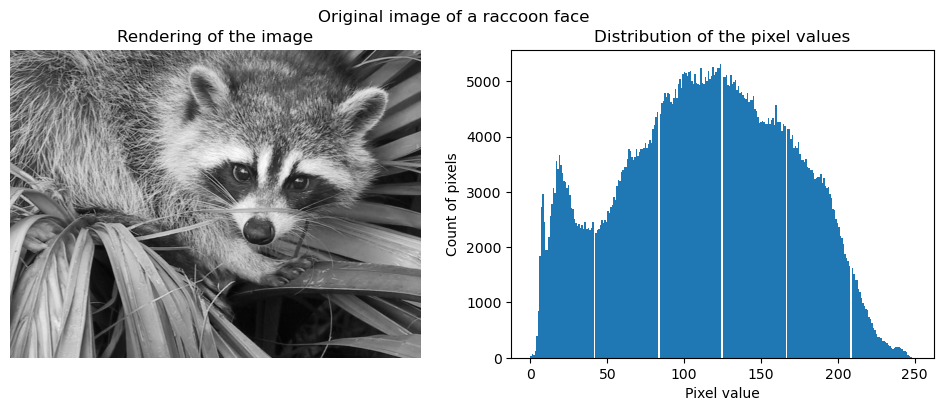

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].imshow(raccoon_face, cmap=plt.cm.gray)
ax[0].axis("off")
ax[0].set_title("Rendering of the image")
ax[1].hist(raccoon_face.ravel(), bins=256)
ax[1].set_xlabel("Pixel value")
ax[1].set_ylabel("Count of pixels")
ax[1].set_title("Distribution of the pixel values")
_ = fig.suptitle("Original image of a raccoon face")

The idea behind compression via vector quantization is to reduce the number of gray levels to represent an image. For instance, we can use 8 values instead of 256 values. Therefore, it means that we could efficiently use 3 bits instead of 8 bits to encode a single pixel and therefore reduce the memory usage by a factor of approximately 2.5. We will later discuss about this memory usage.

#### Encoding strategy
The compression can be done using a KBinsDiscretizer. We need to choose a strategy to define the 8 gray values to sub-sample. The simplest strategy is to define them equally spaced, which correspond to setting strategy="uniform". From the previous histogram, we know that this strategy is certainly not optimal.

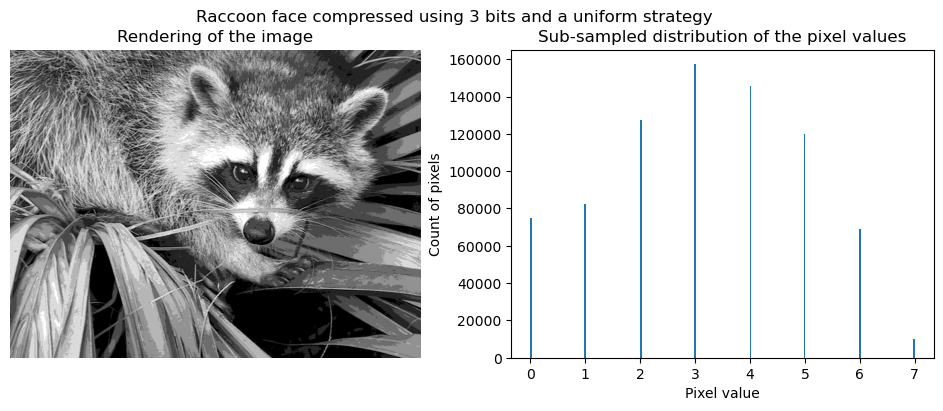

In [7]:
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 8
encoder = KBinsDiscretizer(
    n_bins=n_bins,
    encode="ordinal",
    strategy="uniform",
    random_state=0,
)
compressed_raccoon_uniform = encoder.fit_transform(raccoon_face.reshape(-1, 1)).reshape(
    raccoon_face.shape
)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].imshow(compressed_raccoon_uniform, cmap=plt.cm.gray)
ax[0].axis("off")
ax[0].set_title("Rendering of the image")
ax[1].hist(compressed_raccoon_uniform.ravel(), bins=256)
ax[1].set_xlabel("Pixel value")
ax[1].set_ylabel("Count of pixels")
ax[1].set_title("Sub-sampled distribution of the pixel values")
_ = fig.suptitle("Raccoon face compressed using 3 bits and a uniform strategy")

Qualitatively, we can spot some small regions where we see the effect of the compression (e.g. leaves on the bottom right corner). But after all, the resulting image is still looking good.

We observe that the distribution of pixels values have been mapped to 8 different values. We can check the correspondence between such values and the original pixel values.

In [8]:
bin_edges = encoder.bin_edges_[0]
bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2
bin_center

array([ 15.5625,  46.6875,  77.8125, 108.9375, 140.0625, 171.1875,
       202.3125, 233.4375])

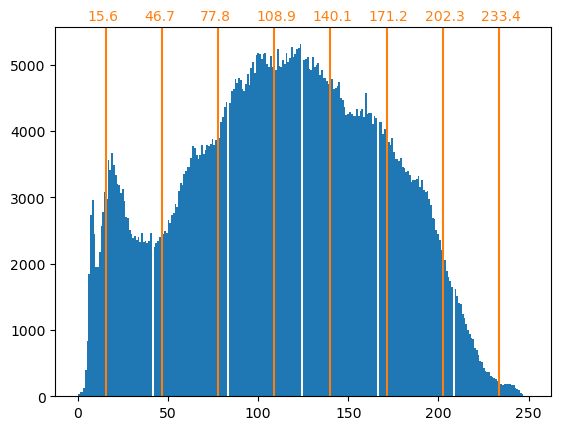

In [9]:
_, ax = plt.subplots()
ax.hist(raccoon_face.ravel(), bins=256)
color = "tab:orange"
for center in bin_center:
    ax.axvline(center, color=color)
    ax.text(center - 10, ax.get_ybound()[1] + 100, f"{center:.1f}", color=color)

As previously stated, the uniform sampling strategy is not optimal. Notice for instance that the pixels mapped to the value 7 will encode a rather small amount of information, whereas the mapped value 3 will represent a large amount of counts. We can instead use a clustering strategy such as k-means to find a more optimal mapping.

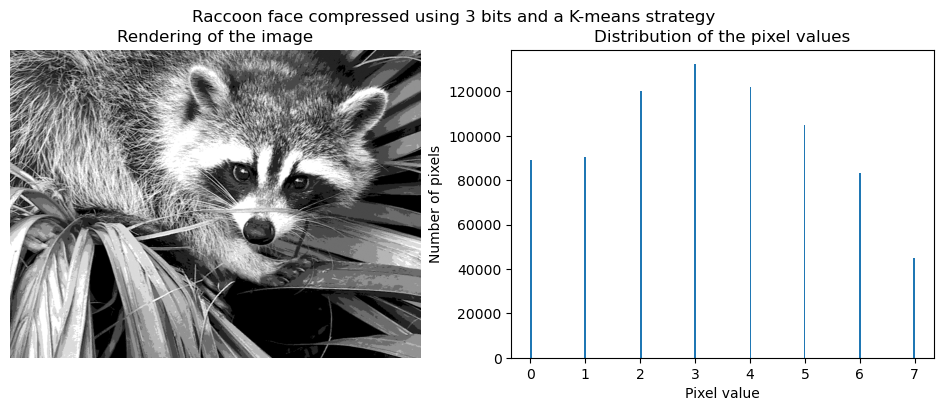

In [10]:
encoder = KBinsDiscretizer(
    n_bins=n_bins,
    encode="ordinal",
    strategy="kmeans",
    random_state=0,
)
compressed_raccoon_kmeans = encoder.fit_transform(raccoon_face.reshape(-1, 1)).reshape(
    raccoon_face.shape
)

fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].imshow(compressed_raccoon_kmeans, cmap=plt.cm.gray)
ax[0].axis("off")
ax[0].set_title("Rendering of the image")
ax[1].hist(compressed_raccoon_kmeans.ravel(), bins=256)
ax[1].set_xlabel("Pixel value")
ax[1].set_ylabel("Number of pixels")
ax[1].set_title("Distribution of the pixel values")
_ = fig.suptitle("Raccoon face compressed using 3 bits and a K-means strategy")

In [11]:
bin_edges = encoder.bin_edges_[0]
bin_center = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1]) / 2
bin_center

array([ 18.90934343,  53.33478066,  82.59678424, 109.22385188,
       134.67876527, 159.67877978, 184.72384803, 223.17132867])

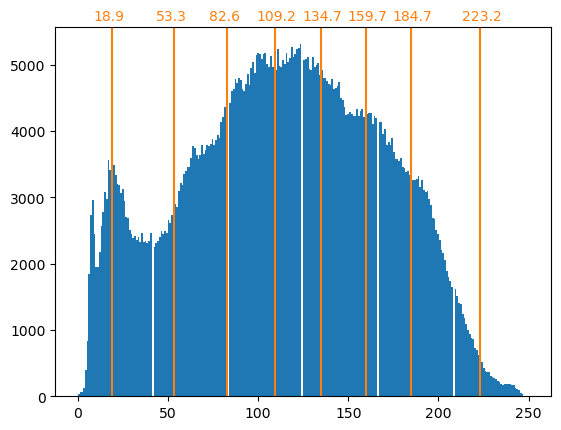

In [12]:
_, ax = plt.subplots()
ax.hist(raccoon_face.ravel(), bins=256)
color = "tab:orange"
for center in bin_center:
    ax.axvline(center, color=color)
    ax.text(center - 10, ax.get_ybound()[1] + 100, f"{center:.1f}", color=color)

The counts in the bins are now more balanced and their centers are no longer equally spaced. Note that we could enforce the same number of pixels per bin by using the strategy="quantile" instead of strategy="kmeans".

#### Memory footprint
We previously stated that we should save 8 times less memory. Let’s verify it.

In [13]:
print(f"The number of bytes taken in RAM is {compressed_raccoon_kmeans.nbytes}")
print(f"Compression ratio: {compressed_raccoon_kmeans.nbytes / raccoon_face.nbytes}")

The number of bytes taken in RAM is 6291456
Compression ratio: 8.0


It is quite surprising to see that our compressed image is taking x8 more memory than the original image. This is indeed the opposite of what we expected. The reason is mainly due to the type of data used to encode the image.

In [14]:
print(f"Type of the compressed image: {compressed_raccoon_kmeans.dtype}")

Type of the compressed image: float64


Indeed, the output of the KBinsDiscretizer is an array of 64-bit float. It means that it takes x8 more memory. However, we use this 64-bit float representation to encode 8 values. Indeed, we will save memory only if we cast the compressed image into an array of 3-bits integers. We could use the method numpy.ndarray.astype. However, a 3-bits integer representation does not exist and to encode the 8 values, we would need to use the 8-bit unsigned integer representation as well.

In practice, observing a memory gain would require the original image to be in a 64-bit float representation.